# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

In [1]:
!pip install -U bitsandbytes
!pip install -U transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `mistral-token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `mist

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [4]:
import os
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import numpy as np
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, classification_report
from IPython.display import display, HTML
from wordcloud import WordCloud
from collections import Counter
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [147]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/"
json_files = ["a2_test.csv", "demonstrations.csv"]
local_dir = Path("Assignment2/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        dataframes[file_name] = pd.read_csv(file)

Downloaded a2_test.csv
Downloaded demonstrations.csv


In [148]:
test_data = dataframes['a2_test.csv']

In [149]:
test_data.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

### Mistral

In [8]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

model_card = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(model_card)
tokenizer.pad_token = tokenizer.eos_token

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [9]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_1 = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Llama

In [10]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

model_card2 = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer2 = AutoTokenizer.from_pretrained(model_card2)
tokenizer2.pad_token = tokenizer2.eos_token

terminators2 = [
    tokenizer2.eos_token_id,
    tokenizer2.convert_tokens_to_ids("<|eot_id|>")]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [11]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_2 = AutoModelForCausalLM.from_pretrained(
    model_card2,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [74]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [13]:
def prepare_prompts(texts, prompt_template, tokenizer, max_length=512):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    # Create prompts by filling the text in the 'user' part of the template
    prompts = []
    for text in texts:
        # Copy the template to avoid modifying the original
        current_prompt = [
            {
                'role': entry['role'],
                'content': entry['content'].format(text=text) if '{text}' in entry['content'] else entry['content']
            }
            for entry in prompt_template
        ]
        prompts.append(current_prompt)

    print('Prompt[0]:', prompts[0])

    # Tokenize the prompts (flattened into strings for tokenizer compatibility)
    tokenized_outputs = tokenizer(
        [f"{entry['role']}: {entry['content']}" for prompt in prompts for entry in prompt],
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    return tokenized_outputs, prompts

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

### Mistral

In [14]:
prepared_prompts_tokenized_zero_shot1, prepared_prompts_zero_shot1 = prepare_prompts(test_data['text'], prompt, tokenizer)

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        TEXT:\n        The boys must be gaming because there goes the wifi.\n\n        ANSWER:\n        '}]


### Llama

In [15]:
prepared_prompts_tokenized_zero_shot2, prepared_prompts_zero_shot2 = prepare_prompts(test_data['text'], prompt, tokenizer2)

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        TEXT:\n        The boys must be gaming because there goes the wifi.\n\n        ANSWER:\n        '}]


# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [16]:
from transformers import pipeline

def generate_responses(model, prompt_examples, tok):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """

  pipe = pipeline(
      "text-generation",
      model=model,
      tokenizer=tok,
      torch_dtype=torch.bfloat16,
      device_map="auto",
  )

  sequences = pipe(
      prompt_examples,
      max_new_tokens=10,
  )

  return sequences

In [59]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """

  response = response[0]['generated_text'][-1]['content']
  normalized_response = response.strip().upper()

  fail_count = 0

  # Map the response to binary labels
  if (normalized_response == "YES") or ("YES" in normalized_response[:3]):
      return 1, fail_count
  elif (normalized_response == "NO") or ("NO" in normalized_response[:2]):
      return 0, fail_count
  else:
      fail_count = 1
      return 0, fail_count

### Mistral

In [18]:
responses_zero_shot_1 = generate_responses(model_1, prepared_prompts_zero_shot1, tokenizer)

Device set to use cuda:0


KeyboardInterrupt: 

### Llama

In [ ]:
responses_zero_shot_2 = generate_responses(model_2, prepared_prompts_zero_shot2, tokenizer2)

## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [19]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  # Ensure responses and y_true are of the same length
  if len(responses) != len(y_true):
      raise ValueError("The number of responses must match the number of ground-truth labels.")

  # Process responses to convert them into binary predictions
  y_pred, fails = zip(*[process_response(response) for response in responses])

  # Compute metrics
  total_samples = len(y_true)
  correct_predictions = sum([1 for pred, true in zip(y_pred, y_true) if pred == true])
  total_failures = sum(fails)
  # total_failures = sum([1 for pred, true in zip(y_pred, y_true) if pred != true])

  accuracy = correct_predictions / total_samples
  fail_ratio = total_failures / total_samples

  return {
      "predictions": list(y_pred),
      "accuracy": accuracy,
      "fail_ratio": fail_ratio,
  }

In [20]:
test_data['label_sexist'] = test_data['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)

### Mistral

In [ ]:
metrics_dict_zero_shot_1 = compute_metrics(responses_zero_shot_1, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_zero_shot_1['accuracy']}, Fail ratio: {metrics_dict_zero_shot_1['fail_ratio']}")

### Llama

In [ ]:
metrics_dict_zero_shot_2 = compute_metrics(responses_zero_shot_2, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_zero_shot_2['accuracy']}, Fail ratio: {metrics_dict_zero_shot_2['fail_ratio']}")

# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [73]:
prompt_example = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [22]:
prompt_example = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [23]:
demonstrations = dataframes['demonstrations.csv']

In [24]:
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


## SPEGARE COME ABBIAMO IMPLEMENTATO STA FUNCIONE

In [133]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
    """
        Inputs:
        demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
        num_per_class: number of demonstrations per class


        Outputs:
        a list of textual demonstrations to inject into the prompt template.
    """
    # Group by class and sample demonstrations
    few_shot_examples = []
    grouped = demonstrations.groupby("label_sexist")
    for _ in range(len(test_data)):
        examples = []
        for label, group in grouped:
            sampled = group.sample(n=min(num_per_class, len(group)))
            examples.extend(sampled["text"].tolist())

        example_str = ''
        for i in range(len(examples)):
            example_str += '\nTEXT: ' + examples[i] + '\nANSWER: ' + ('NO' if i < num_per_class else 'YES')

        few_shot_examples.append(example_str)

    return few_shot_examples


In [150]:
num_per_class = 2
few_shot_examples = build_few_shot_demonstrations(demonstrations, num_per_class)

In [151]:
for i in range(10):
    print(few_shot_examples[i])


TEXT: Greece, African and moslems first stop to the UK.
ANSWER: NO
TEXT: "Yuck" "ew" "Get away from me" "Disgusting" I stopped engaging girls a long time ago. Confidence isn't attainable when it's nuked from time to time.
ANSWER: NO
TEXT: Well.....At least she has decent Tits. There's nothing worse than a fat chick with no Tits. You have all of that fat to deal with but no fun bags to play with.
ANSWER: YES
TEXT: Yup, like any female mammalian species, it's the fight to obtain as many resources as you can so you can raise your kid and pass on the genes.
ANSWER: YES

TEXT: ROFLMAO.... She's a little thing so ducking to her level is ill advised
ANSWER: NO
TEXT: No, an ugly woman will still have more value than an ugly man
ANSWER: NO
TEXT: She was arrested. A white European or American "wxmxn" Would probably have been released from jail after the trial. A white European or American mxn would sit in jail till their death.
ANSWER: YES
TEXT: So she tried to save herself with a preemptive st

In [136]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [140]:
def prepare_prompts_few_shot(texts, prompt_template, tokenizer, examples, max_length=512, num_per_class=2):
    """
    Prepares prompts with few-shot examples and tokenizes them.

    Args:
        texts: List of input texts for the prompts.
        prompt_template: Template for the prompts, a list of role-content dictionaries.
        tokenizer: Tokenizer to use for encoding the prompts.
        examples: List of few-shot examples to insert where `{examples}` is encountered.
        max_length: Maximum length for tokenized outputs.
        num_per_class: Number of examples to include per class in `{examples}`.

    Returns:
        Tokenized outputs and prepared prompts.
    """
    # Combine examples into formatted string
    #examples_text = "\n".join(
    #    examples[i % len(examples)] for i in range(2 * num_per_class)
    #)

    prompts = []
    for i, text in enumerate(texts):
        example = examples[i]
        # Create the prompt and insert examples where `{examples}` is found
        current_prompt = [
            {
                'role': entry['role'],
                'content': entry['content']
                .replace("{text}", text)
                .replace("{examples}", example) if '{examples}' in entry['content'] else entry['content']
            }
            for entry in prompt_template
        ]
        prompts.append(current_prompt)

    print('Prompt[0]:', prompts[0])

    # Tokenize the prompts (flattened into strings for tokenizer compatibility)
    tokenized_outputs = tokenizer(
        [f"{entry['role']}: {entry['content']}" for prompt in prompts for entry in prompt],
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    return tokenized_outputs, prompts

### Mistral

In [141]:
tokenized_prompts_few_shot1, prompts_few_shot1 = prepare_prompts_few_shot(test_data['text'], prompt_few_shot, tokenizer, few_shot_examples, num_per_class)

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': "Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        \nTEXT: She's a great role model for women on top of being lovely\nANSWER: NO\nTEXT: ROFLMAO.... She's a little thing so ducking to her level is ill advised\nANSWER: NO\nTEXT: I literally have no standards and will fuck almost any girl. Lots of guys are like me, so it's easy for even below average girls to get laid.\nANSWER: YES\nTEXT: [USER] Chocolate is a real bitch. You can yell n scream all you want, chocolate gives no fucks! ...and she has mean deplorable friends too. #GabChefs\nANSWER: YES\n\n        TEXT:\n        The boys must be gaming because there goes the wifi.\n\n        ANSWER:\n        "}]


In [ ]:
responses_few_shot_1 = generate_responses(model_1, prompts_few_shot1, tokenizer)

In [ ]:
metrics_dict_few_shot_1 = compute_metrics(responses_few_shot_1, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_few_shot_1['accuracy']}, Fail ratio: {metrics_dict_few_shot_1['fail_ratio']}")

### Llama

In [ ]:
tokenized_prompts_few_shot2, prompts_few_shot2 = prepare_prompts_few_shot(test_data['text'], prompt_few_shot, tokenizer2, few_shot_examples, num_per_class)

In [ ]:
responses_few_shot_2 = generate_responses(model_2, prompts_few_shot2, tokenizer2)

In [ ]:
metrics_dict_few_shot_2 = compute_metrics(responses_few_shot_2, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_few_shot_2['accuracy']}, Fail ratio: {metrics_dict_few_shot_2['fail_ratio']}")

## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

## Classification performance comparison

Compare the results obtained by the two analyzed models: Mistral and Llama.

In [31]:
'''
CELLA PER NON DOVER RUNNARE TUTTO, DA TOGLIERE POI
'''

metrics_dict_zero_shot_1 = {'accuracy': 0.5933333333333334, 'fail_ratio': 0.013333333333333334}
metrics_dict_zero_shot_1['predictions'] = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
metrics_dict_zero_shot_2 = {'accuracy': 0.6666666666666666, 'fail_ratio': 0.00}
metrics_dict_zero_shot_2['predictions'] = [0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]

metrics_dict_few_shot_1 = {'accuracy': 0.7333333333333333, 'fail_ratio': 0.08}
metrics_dict_few_shot_1['predictions'] = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
metrics_dict_few_shot_2 = {'accuracy': 0.6933333333333334, 'fail_ratio': 0.0}
metrics_dict_few_shot_2['predictions'] = [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]

In [32]:
from tabulate import tabulate

def display_metrics_table(metrics_dict_zero_shot_1, metrics_dict_zero_shot_2,
                          metrics_dict_few_shot_1, metrics_dict_few_shot_2, labels):
    """
    Takes four dictionaries of metrics and displays them as a formatted table.
    """
    # Extract data
    data = {
        'Model': [f'Zero-shot {labels[0]}', f'Zero-shot {labels[1]}', f'Few-shot {labels[0]}', f'Few-shot {labels[1]}'],
        'Accuracy': [
            metrics_dict_zero_shot_1.get('accuracy', 0),
            metrics_dict_zero_shot_2.get('accuracy', 0),
            metrics_dict_few_shot_1.get('accuracy', 0),
            metrics_dict_few_shot_2.get('accuracy', 0),
        ],
        'Fail Ratio': [
            metrics_dict_zero_shot_1.get('fail_ratio', 0),
            metrics_dict_zero_shot_2.get('fail_ratio', 0),
            metrics_dict_few_shot_1.get('fail_ratio', 0),
            metrics_dict_few_shot_2.get('fail_ratio', 0),
        ],
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Use tabulate to format the table nicely
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

display_metrics_table(metrics_dict_zero_shot_1, metrics_dict_zero_shot_2,
                                metrics_dict_few_shot_1, metrics_dict_few_shot_2,
                                labels=['MISTRAL', 'LLAMA'])

╒═══════════════════╤════════════╤══════════════╕
│ Model             │   Accuracy │   Fail Ratio │
╞═══════════════════╪════════════╪══════════════╡
│ Zero-shot MISTRAL │   0.593333 │    0.0133333 │
├───────────────────┼────────────┼──────────────┤
│ Zero-shot LLAMA   │   0.666667 │    0         │
├───────────────────┼────────────┼──────────────┤
│ Few-shot MISTRAL  │   0.733333 │    0.08      │
├───────────────────┼────────────┼──────────────┤
│ Few-shot LLAMA    │   0.693333 │    0         │
╘═══════════════════╧════════════╧══════════════╛


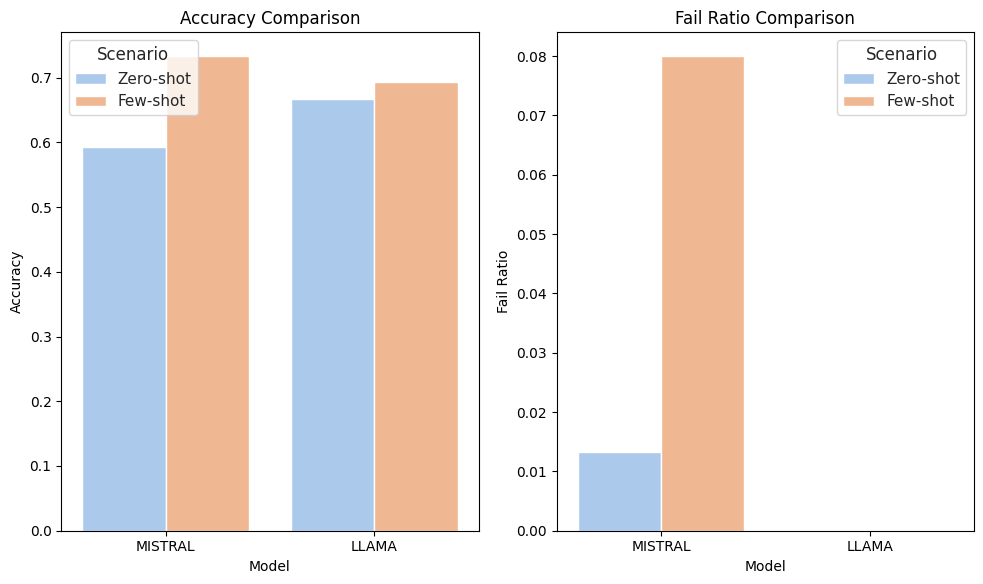

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_llm_performance_comparison(metrics_dict_zero_shot_1, metrics_dict_zero_shot_2,
                                     metrics_dict_few_shot_1, metrics_dict_few_shot_2, labels=["LLM1", "LLM2"]):
    """
    Generate performance comparison bar plots for two LLMs in zero-shot and few-shot scenarios.
    """
    scenarios = ["Zero-shot", "Few-shot"]

    data = {
        "Model": [labels[0], labels[1], labels[0], labels[1]],
        "Scenario": ["Zero-shot", "Zero-shot", "Few-shot", "Few-shot"],
        "Accuracy": [
            metrics_dict_zero_shot_1["accuracy"], metrics_dict_zero_shot_2["accuracy"],
            metrics_dict_few_shot_1["accuracy"], metrics_dict_few_shot_2["accuracy"]
        ],
        "Fail Ratio": [
            metrics_dict_zero_shot_1["fail_ratio"], metrics_dict_zero_shot_2["fail_ratio"],
            metrics_dict_few_shot_1["fail_ratio"], metrics_dict_few_shot_2["fail_ratio"]
        ]
    }

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    sns.set(style="whitegrid")

    for i, metric in enumerate(["Accuracy", "Fail Ratio"]):
        sns.barplot(
            data=df, x="Model", y=metric, hue="Scenario", ax=axes[i], palette='pastel'
        )
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel("Model")
        axes[i].legend(title="Scenario")

    plt.tight_layout()
    plt.show()

plot_llm_performance_comparison(metrics_dict_zero_shot_1, metrics_dict_zero_shot_2,
                                metrics_dict_few_shot_1, metrics_dict_few_shot_2,
                                labels=['MISTRAL', 'LLAMA'])

The plots of the evaluated metrics show that:
 * Accuracy plot
  * For both models, accuracy is higher in the few-shot scenario compared to the zero-shot scenario, which aligns with expectations since few-shot inference benefits from additional demonstration examples.
  * The Mistral model demonstrates a substantial improvement when using few-shot inference, with accuracy increasing from 59% to 73%. In contrast, the Llama model shows a smaller improvement, with accuracy rising only marginally from 66% to 69%.
  * In the zero-shot configuration, the Llama model outperforms the Mistral model by a significant margin, indicating better generalization without prior examples.
 * Fail-ratio plot
  * The Llama model performs no errors in the output, showing a more reliable and consistent response, following accurately the instructions given by the classification task.
  * The Mistral model instead produces some responses that are different from the requested ('YES' and 'NO'). In particular, the prompt with few-shot outputs more errors, probably due to the larger context to analyze. These considerations are true, but it is important to notice that the rate of failures over the whole dataset is low (1.3% and 8%).





### Confusion Matrix comparison

In [44]:
def plot_confusion_and_classification_report(y_pred, y_test):
    """
    Given binary labels (y_test) and binary predictions (y_pred),
    this function plots the confusion matrix as a heatmap and the classification report as a styled table.
    """
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix Heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"], ax=ax1)
    ax1.set_title("Confusion Matrix", fontsize=14)
    ax1.set_xlabel("Predicted", fontsize=12)
    ax1.set_ylabel("Actual", fontsize=12)

    # Classification Report Table
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Round numeric values to 2 decimal places
    report_df.iloc[:, :-1] = report_df.iloc[:, :-1].round(2)
    report_df.loc["accuracy", ["precision", "recall"]] = None
    report_df.loc["accuracy", "support"] = 300

    # Create a styled table with nicer formatting
    ax2.axis("off")
    table_data = report_df.reset_index()
    table = ax2.table(cellText=table_data.values, colLabels=table_data.columns,
                      cellLoc="center", loc="center", bbox=[0, 0, 1, 1])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(table_data.columns))))

    # Apply styles to headers and rows
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        if row == 0:  # Header row
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f4f4f4")
        elif col == 0:  # First column (index)
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f4f4f4")  # Light grey for readability
        else:  # All other cells
            value = table_data.values[row - 1, col] if row > 0 else table_data.columns[col]  # Adjust index for header
            if pd.isna(value):
                cell.get_text().set_text("")
            cell.set_facecolor("white")
            cell.set_alpha(0.9)

    ax2.set_title("Classification Report", fontsize=14)

    plt.tight_layout()
    plt.show()

#### Minstral

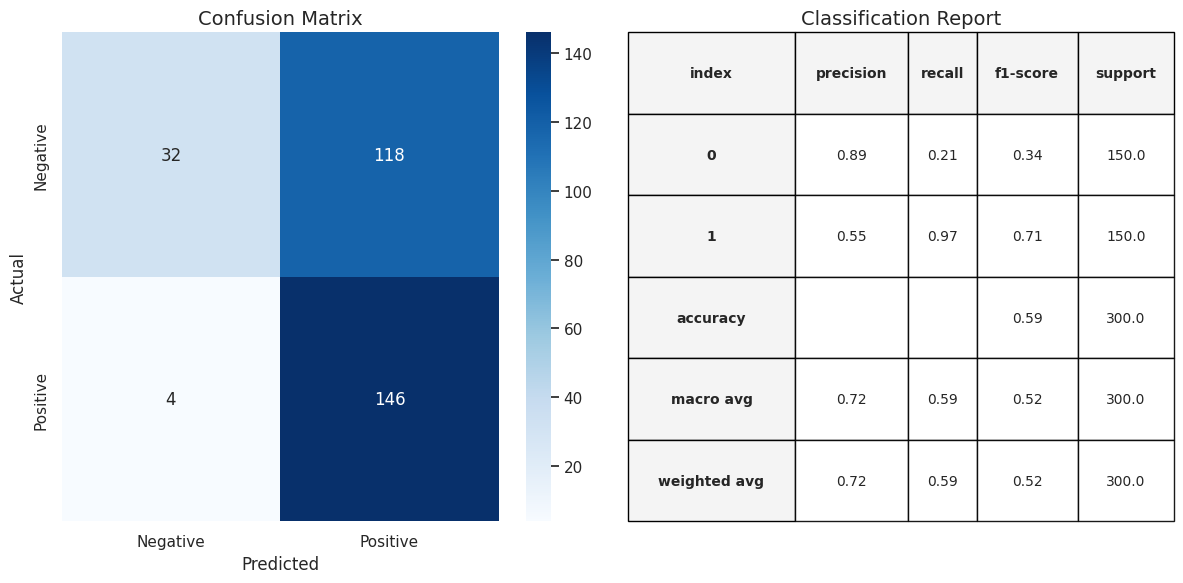

In [45]:
plot_confusion_and_classification_report(metrics_dict_zero_shot_1['predictions'], test_data['label_sexist'])

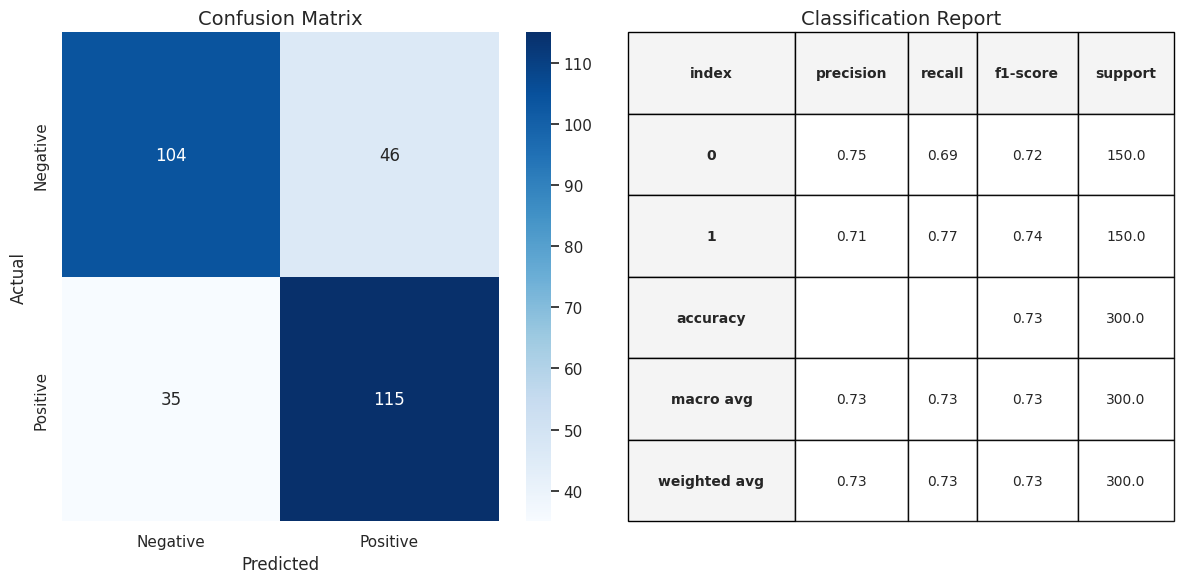

In [46]:
plot_confusion_and_classification_report(metrics_dict_few_shot_1['predictions'], test_data['label_sexist'])

The zero-shot model demonstrates a strong bias towards the positive class, resulting in high recall for positive tweets (0.97) but at the expense of significant false positives (118). This leads to poor performance in identifying negative tweets, with a recall of just 0.21. While its precision for negative tweets is high (0.89), the overall accuracy is only 0.59, reflecting an imbalanced performance.

In contrast, the few-shot model shows a more balanced approach. By using task-specific examples in the prompt, it reduces false positives (from 118 to 46) and improves recall for the negative class (from 0.21 to 0.69). This results in better precision and recall across both classes, achieving an overall accuracy of 0.73 and a macro-average F1-score of 0.73, compared to 0.59 for the zero-shot model. The trade-off is a slight decrease in recall for the positive class (from 0.97 to 0.77) as the model now prioritizes balanced performance.

The improvement in the few-shot setup can be attributed to the task-specific examples provided, which help the model better understand the distinctions between the two classes. While the zero-shot model might suffice when detecting the positive class is critical, the few-shot model is a more reliable choice for real-world applications requiring overall accuracy and balanced performance.

#### LLama

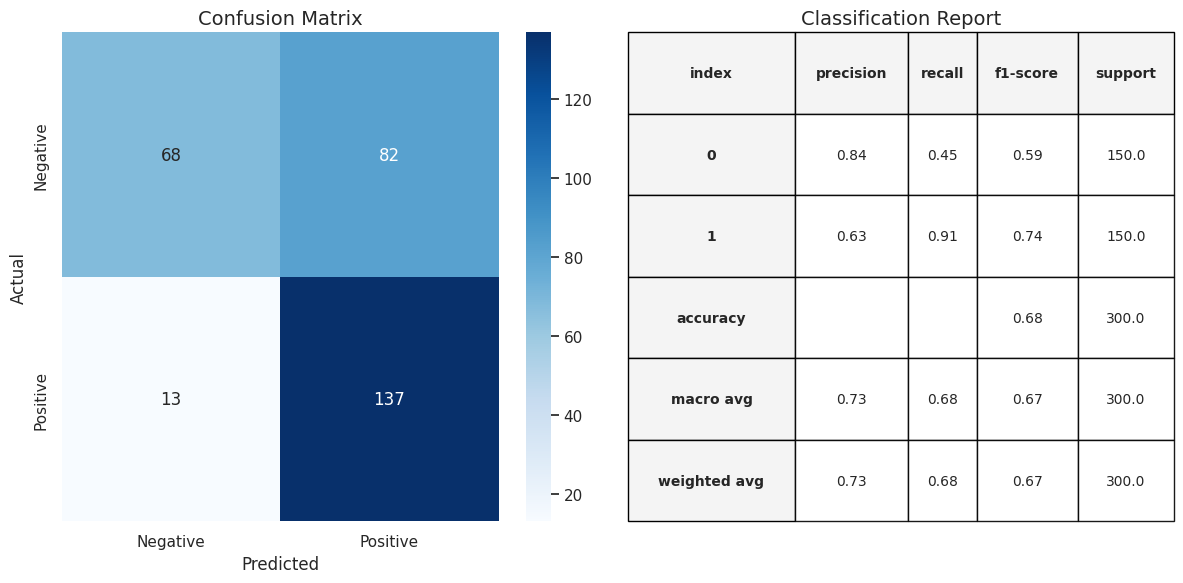

In [48]:
plot_confusion_and_classification_report(metrics_dict_zero_shot_2['predictions'], test_data['label_sexist'])

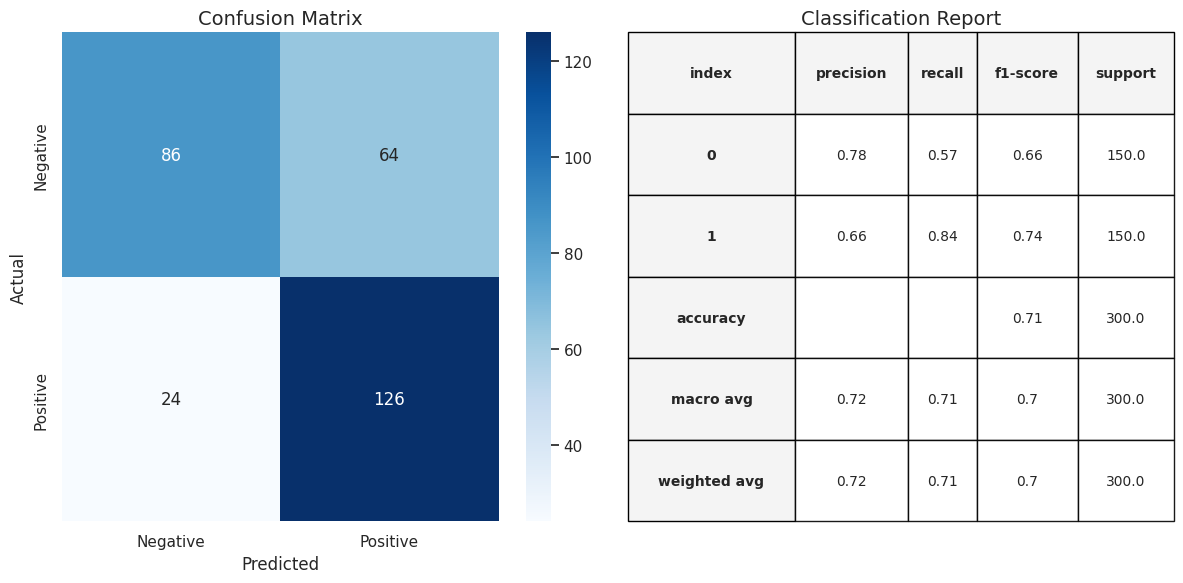

In [47]:
plot_confusion_and_classification_report(metrics_dict_few_shot_2['predictions'], test_data['label_sexist'])

The zero-shot model has a lower overall accuracy (0.68) compared to the few-shot model (0.71). The zero-shot model performs better at recalling positive tweets (0.91) but struggles with identifying negative ones (recall: 0.45). In contrast, the few-shot model improves both precision and recall for negative tweets (precision: 0.78, recall: 0.57), while its performance on positive tweets is slightly less precise (precision: 0.66, recall: 0.84). The few-shot model benefits from task-specific examples, allowing it to generalize better, especially for the negative class. This suggests that the few-shot model is more balanced, while the zero-shot model is biased towards predicting positive tweets.








#### Model Comparison

In comparing the two LLMs, LLama performs better in zero-shot prompting by achieving higher accuracy and a more balanced macro F1-score, as it handles both classes more effectively. In contrast, Mistral struggles in this setting, showing a strong bias toward predicting the positive class, which results in poor recall for the negative class. However, in the few-shot prompting scenario, Mistral slightly outperforms LLama by achieving higher accuracy and improved recall for the negative class, demonstrating its ability to better adapt when examples are provided. Meanwhile, LLama continues to prioritize the positive class, maintaining strong performance but with slightly lower overall balance. Overall, LLama excels in generalization during zero-shot prompting, while Mistral demonstrates greater improvement with the additional context provided by few-shot prompting. Both LLMs show significant gains when given examples, but their strengths vary depending on the prompting strategy.

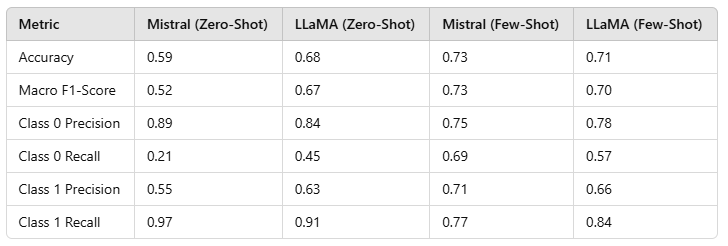

### Text generation analysis

Let's modify the process_response function to visualize what happens when the model fails to generate a response, we are not intreseted in the cases when it is right since we know it will be only YES or NO, that is also why the analysisi will only be about Minstral


In [49]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """

  response = response[0]['generated_text'][-1]['content']
  normalized_response = response.strip().upper()

  fail_count = 0

  # Map the response to binary labels
  if normalized_response == "YES":
      return 1, fail_count
  else:
      if normalized_response != "NO":
          print(normalized_response)
          fail_count = 1
      return 0, fail_count

In [50]:
metrics_dict_zero_shot_1 = compute_metrics(responses_zero_shot_1, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_zero_shot_1['accuracy']}, Fail ratio: {metrics_dict_zero_shot_1['fail_ratio']}")

NameError: name 'responses_zero_shot_1' is not defined

In [51]:
metrics_dict_few_shot_1 = compute_metrics(responses_few_shot_1, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_few_shot_1['accuracy']}, Fail ratio: {metrics_dict_few_shot_1['fail_ratio']}")

NameError: name 'responses_few_shot_1' is not defined


We can observe several issues:

First, the model provides responses that are coherent and follow instructions, but it often includes an unnecessary explanation of why it judged the response a certain way. This breaks the parsing of its output.

Second, as noted in earlier analyses, the few-shot model has a higher failure rate. Specifically, it tends to add explanations more frequently. This could be because providing examples creates a longer prompt, which may lead to reduced attention to the initial instructions (e.g., to respond with "yes" or "no" only). Additionally, a longer promt increases the risk of cutting off the initial sentences depending on the context window of the model, including critical instructions.

To address this, we could implement more advanced response parsing techniques to reliably extract "yes" or "no" answers from the output. This approach would reduce the failure rate but would not necessarily improve accuracy since most errors already occur with "no" responses, which are already counted as 0.

## A1 Dataset comparison

We will use test to test the performance of the LLM on the classificatio task and validation to generate few shot examples

In [163]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"
json_files = ["test.json", "validation.json"]
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)


def determine_majority(response_list):
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")

    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2


def transform_df(df):
    # Swap row and col
    df = df.T
    # Apply majority voting to task 1
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    # Keep only row that has en as lang and does not have a draw in voting
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    # Drop unecessary columns
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
    df = df.rename(columns={"tweet":"text", "hard_label_task1": "label_sexist"})

    return df


def clean_tweet(tweet):
    """
    Cleans a tweet by removing unwanted characters, URLs, hashtags, mentions, and stopwords,
    and by performing lemmatization.
    """
    # Remove mentions
    tweet = re.sub(r'@\w+', '[USER]', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '[URL]', tweet)

    return tweet


# Load the original datasets from the specified JSON files into separate DataFrames
demonstrations = transform_df(dataframes['validation.json'])
test_data = transform_df(dataframes['test.json'])

# Substitute URLs and mentions with placeholders
test_data['text'] = test_data['text'].apply(clean_tweet)
demonstrations['text'] = demonstrations['text'].apply(clean_tweet)

Downloaded test.json
Downloaded validation.json


Get rid of emoji, change urls with [URL] and [USER]

In [153]:
# Mistral
prepared_prompts_tokenized_zero_shot1, prepared_prompts_zero_shot1 = prepare_prompts(test_data['text'], prompt, tokenizer)
# LLama
prepared_prompts_tokenized_zero_shot2, prepared_prompts_zero_shot2 = prepare_prompts(test_data['text'], prompt, tokenizer2)

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        TEXT:\n        1st day at the pool on a beautiful Sunday in NY! Too bad few dared to go in due to the frigid water temp (we lasted 45 min and figured we proved our point) 😆 https://t.co/4CZqD4CW2x\n\n        ANSWER:\n        '}]
Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        TEXT:\n        1st day at the pool on a beautiful Sunday in NY! Too bad few dared to go in due to the frigid water temp (we lasted 45 min and figured we proved our point) 😆 https://t.co/4CZqD4CW2x\n\n        ANSWER:\n        '}]


In [154]:
# Mistral
responses_zero_shot_1 = generate_responses(model_1, prepared_prompts_zero_shot1, tokenizer)
# LLama
responses_zero_shot_2 = generate_responses(model_2, prepared_prompts_zero_shot2, tokenizer2)

Device set to use cuda:0


KeyboardInterrupt: 

In [104]:
# Mistral
metrics_dict_zero_shot_1 = compute_metrics(responses_zero_shot_1, test_data['label_sexist'])
print(f"MISTRAL -> Accuracy: {metrics_dict_zero_shot_1['accuracy']}, Fail ratio: {metrics_dict_zero_shot_1['fail_ratio']}")
# LLama
metrics_dict_zero_shot_2 = compute_metrics(responses_zero_shot_2, test_data['label_sexist'])
print(f"LLAMA -> Accuracy: {metrics_dict_zero_shot_2['accuracy']}, Fail ratio: {metrics_dict_zero_shot_2['fail_ratio']}")

Accuracy: 0.7552447552447552, Fail ratio: 0.0
Accuracy: 0.7657342657342657, Fail ratio: 0.0


In [164]:
num_per_class = 2
few_shot_examples = build_few_shot_demonstrations(demonstrations, num_per_class)

In [165]:
print(few_shot_examples[0])


TEXT: they get the MOST hate, so much so that they’re bullied out and most of them are just western stans now😭😭 [URL]
ANSWER: NO
TEXT: [USER] are all skittles the same flavor?? The people deserve to know
ANSWER: NO
TEXT: Call me sexist, but I don't believe women evolved to prefer men who are stronger, taller, more mature, more intelligent and have more resources than them, so that they could wear the pants in that relationship.
ANSWER: YES
TEXT: #everydaysexism Some man moving my suitcase in the overhead luggage storage on a train to what he thinks is a better position (why?!) and now completely out of my reach for when I have to rush off the train in a couple of stops. Women can't arrange their own luggage, apparently.
ANSWER: YES


In [108]:
# Mistral
tokenized_prompts_few_shot1, prompts_few_shot1 = prepare_prompts_few_shot(test_data['text'], prompt_few_shot, tokenizer, few_shot_examples, num_per_class)
responses_few_shot_1 = generate_responses(model_1, prompts_few_shot1, tokenizer)
metrics_dict_few_shot_1 = compute_metrics(responses_few_shot_1, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_few_shot_1['accuracy']}, Fail ratio: {metrics_dict_few_shot_1['fail_ratio']}")

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        TEXT: they get the MOST hate, so much so that they’re bullied out and most of them are just western stans now😭😭 https://t.co/1LpxPj54gX\nANSWER: NO\nTEXT: ⚡Flashback⚡: In May 1994, Sonic Youth released their eighth studio album "Experimental Jet Set, Trash and No Star". The album features "Bull in the Heather", and “Androgynous Mind".  #sonicyouth #noise #indierock #avantgarde #recordshop #flashback https://t.co/ljzjsBCNIF\nANSWER: NO\nTEXT: @edwardhenry1 Seriously Edward I am disappointed in you.  Telling women (never men) to smile at work is based on the assumption we are decorative and there to look pretty.  You don’t suffer everyday sexism but silencing those who experience it and dismissing the impact of it is shameful.\nANSWER: YES\nTEXT: @realwil

Device set to use cuda:0


Accuracy: 0.8181818181818182, Fail ratio: 0.0


In [144]:
# LLama
tokenized_prompts_few_shot2, prompts_few_shot2 = prepare_prompts_few_shot(test_data['text'], prompt_few_shot, tokenizer2, few_shot_examples, num_per_class)
responses_few_shot_2 = generate_responses(model_2, prompts_few_shot2, tokenizer2)
metrics_dict_few_shot_2 = compute_metrics(responses_few_shot_2, test_data['label_sexist'])
print(f"Accuracy: {metrics_dict_few_shot_2['accuracy']}, Fail ratio: {metrics_dict_few_shot_2['fail_ratio']}")

Prompt[0]: [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        \nTEXT: @KariLake This is child abuse . There’s laws for child abuse. Get them teachers put away. It will stop.\nANSWER: NO\nTEXT: @LaurenRazavi @xdamman @MrsBadgerface @trinetti @Montebello - define who is your community &amp; why are you uniting- think deeply about permissionless/open vs curated communities (onboarding)- avoid ranking, create equality between whomever is giving, using &amp; receiving - be present, listen (x3)- cocreate- reward and praise- see people\nANSWER: NO\nTEXT: Shit is crazy. If u want an open relationship, go find someone who wants the same thing as you. why is this a logic that man can’t grasp? This man is tryna downplay him entertaining other bitches. Not every girl is gon stay after you cheat. Like get this patriarchy bs ou

Device set to use cuda:0


KeyboardInterrupt: 

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End